<a href="https://colab.research.google.com/github/david-j-cox/Man-vs-Machine/blob/master/GME_fits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the packages we'll be using and read in the data set

In [ ]:
# Packages we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import zipfile, io, os
import math
import time
import seaborn as sns
# from google.colab import files
# files.upload()
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/GME & MLB/Data_and_Fits'

Mounted at /content/gdrive
/content/gdrive/My Drive/GME & MLB/Data_and_Fits


# Make sure dataframe is ready for fitting

In [ ]:
# Read in file
data_raw = pd.read_csv("all_pitches_08_19.csv").drop(['Unnamed: 0'], axis=1)
# data_raw = data_raw.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
data = data_raw.copy()
data[::300000] # Take a look at every 300,000 row of the df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (44,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


pitch_type   game_date  ...  if_fielding_alignment  of_fielding_alignment
0               FF  2019-09-29  ...               Standard               Standard
300000          FF   6/12/2013  ...                    NaN                    NaN
600000          FF    8/5/2015  ...               Standard               Standard
900000          FF  2019-04-14  ...          Infield shift               Standard
1200000         FF  2015-06-23  ...               Standard              Strategic
1500000         SL   7/24/2012  ...                    NaN                    NaN
1800000         SL   8/28/2013  ...                    NaN                    NaN
2100000         SI  2018-05-15  ...               Standard               Standard
2400000         FS  2017-07-24  ...               Standard               Standard
2700000         FF   10/3/2015  ...               Standard               Standard
3000000         SL  2019-06-02  ...               Standard               Standard
3300000         FT    7/8/2013  ...                    NaN                    NaN
3600000         SI  2017-09-25  ...               Standard               Standard
3900000         FF  2015-06-27  ...               Standard               Standard
4200000         FF  2019-08-29  ...               Standard               Standard
4500000         SL  2018-05-05  ...               Standard               Standard
4800000         FC  2010-08-13  ...                    NaN                    NaN
5100000         SL  2019-05-22  ...               Standard               Standard
5400000         FT  2012-08-29  ...                    NaN                    NaN
5700000         FF  2012-05-17  ...                    NaN                    NaN
6000000         FT   7/21/2008  ...                    NaN                    NaN
6300000         FF   4/13/2012  ...                    NaN                    NaN
6600000         SI   6/28/2008  ...                    NaN                    NaN
6900000         FF  2017-09-23  ...               Standard               Standard
7200000         SL  2016-06-22  ...               Standard               Standard
7500000         SL  2018-08-28  ...          Infield shift               Standard
7800000         FF  2013-05-11  ...                    NaN                    NaN
8100000         SL  2011-07-14  ...                    NaN                    NaN
8400000         KC  2014-09-01  ...                    NaN                    NaN

[29 rows x 89 columns]

In [ ]:
# Create a list of all the unique pitchers in the df
uniq_p = data.player_name.unique()
uniq_p = uniq_p.tolist()
print("Number of unique pitchers in the dataset:", len(uniq_p))
print("Number of total observations in the dataset:", len(data))

Number of unique pitchers in the dataset: 2374
Number of total observations in the dataset: 8467473


In [ ]:
# Look at all the different pitch types in the dataframe
data['pitch_name'].unique()

array(['4-Seam Fastball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Changeup',
       'Slider', '2-Seam Fastball', 'Curveball', nan, 'Split Finger',
       'Intentional Ball', 'Split-Finger', 'Pitch Out', 'Fastball',
       'Unknown', 'Forkball', 'Knuckleball', 'Eephus', 'Knuckle Ball',
       'Screwball'], dtype=object)

In [ ]:
# Create lists of which pitches fall into which categories
hrd_strt = ['4-Seam Fastball', '2-Seam Fastball', 'Cutter']
hrd_brkng = ['Slider', 'Sinker', 'Split Finger', 'Screwball', 'Forkball']
sft_strt = ['Changeup', 'Knuckle Ball', 'Eephus']
sft_brkng = ['Curveball', 'Knuckle Curve']

In [ ]:
# Look at all the different outcome events
data['description'].unique()

array(['hit_into_play', 'ball', 'called_strike', 'swinging_strike',
       'foul', 'foul_tip', 'swinging_strike_blocked',
       'hit_into_play_no_out', 'blocked_ball', 'hit_by_pitch',
       'hit_into_play_score', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip',
       'intent_ball', 'pitchout', 'swinging_pitchout',
       'pitchout_hit_into_play_no_out', 'pitchout_hit_into_play',
       'pitchout_hit_into_play_score', 'foul_pitchout', 'unknown_strike'],
      dtype=object)

In [ ]:
# Create list of all Strike and out categories to serve as reinforcers
s_o = ['hit_into_play', 'foul','swinging_strike', 'swinging_strike_blocked', \
       'called_strike','foul_bunt', 'foul_tip', 'missed_bunt','swinging_pitchout', \
       'foul_pitchout', 'bunt_foul_tip', 'unknown_strike']

# Fit the GME for each pitcher in the df using strikes and outs as assumed reinforcers

### Caution: This will run for a long time. Break into batches if possible. 

In [ ]:
# Make sure data types are as we need them
data.game_year = data.game_year.astype(int)

player = []
season = []
VAC_strikes = []
bias_strikes = []
sens_strikes = []
player_errors = []
err_type = []

# Pull df for the target pitcher and break down by season
for i in range(len(uniq_p)):
  try:
    # Lists to store things in
    game_number = []
    year = []
    hard_straight_count = []
    hard_breaking_count = []
    soft_straight_count = []
    soft_breaking_count = []
    hard_straight_s_o = []
    hard_breaking_s_o = []
    soft_straight_s_o = []
    soft_breaking_s_o = []

    df = data[data['player_name']==uniq_p[i]]

    for j in [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
      try:
        df_year = df[df['game_year']==j]
        g_uniq = df_year['game_date'].unique()
        if len(g_uniq) < 5:
          continue
        else:
          gnum = 1
          for k in g_uniq:
            game_data = df_year[df_year['game_date']==k]

            if len(game_data) < 5:
              pass
            else:
              # Create dfs for each pitch type
              hard_straight = game_data.loc[game_data.pitch_name.isin(hrd_strt)]
              hard_breaking = game_data.loc[game_data.pitch_name.isin(hrd_brkng)]
              soft_straight = game_data.loc[game_data.pitch_name.isin(sft_strt)]
              soft_breaking = game_data.loc[game_data.pitch_name.isin(sft_brkng)]
              
              # Get the count of each pitch type per game
              hstrt = len(hard_straight)
              hbrk = len(hard_breaking)
              sstrt = len(soft_straight)
              sbrk = len(soft_breaking)

              # Get the count of strikes/outs that followed each pitch type per game
              hstrt_strike = len(hard_straight.loc[hard_straight.description.isin(s_o)])
              hbrk_strike = len(hard_breaking.loc[hard_breaking.description.isin(s_o)])
              sstrt_strike = len(soft_straight.loc[soft_straight.description.isin(s_o)])
              sbrk_strike = len(soft_breaking.loc[soft_breaking.description.isin(s_o)])
              
              # Append the vals to the respective lists
              game_number.append(gnum)
              gnum += 1
              year.append(j)
              # Pitches
              hard_straight_count.append(hstrt)
              hard_breaking_count.append(hbrk)
              soft_straight_count.append(sstrt)
              soft_breaking_count.append(sbrk)
              # Strikes/outs
              hard_straight_s_o.append(hstrt_strike)
              hard_breaking_s_o.append(hbrk_strike)
              soft_straight_s_o.append(sstrt_strike)
              soft_breaking_s_o.append(sbrk_strike)
          
          # Log pitch and outcome ratios using fastball as Bi
          logged_bx = []
          logged_strikes = []

          for l in list(range(len(hard_straight_count))):
            behavior = (hard_straight_count[l]+1)/(hard_breaking_count[l] + soft_straight_count[l] + soft_breaking_count[l]+1)
            strikes = (hard_straight_s_o[l]+1)/(hard_breaking_s_o[l] + soft_straight_s_o[l] + soft_breaking_s_o[l]+1)
            behavior = math.log(behavior, 10)
            strikes = math.log(strikes, 10)
            logged_bx.append(behavior)
            logged_strikes.append(strikes)
          
          # Combine the lists and save df for the pitcher
          count_data = pd.DataFrame({'Year':year, 'Game': game_number, \
                                    'HStrt': hard_straight_count, 'HBrk':hard_breaking_count, \
                                    'SStrt':soft_straight_count,'SBrk':soft_breaking_count, \
                                    'HStrtStrike':hard_straight_s_o, 'HBrkStrike':hard_breaking_s_o, \
                                    'SStrtStrike':soft_straight_s_o, 'SBrkStrike':soft_breaking_s_o, \
                                    'Logged_Bx':logged_bx, 'Logged_Strikes':logged_strikes})
          count_data = count_data.fillna(0)

          # Fit the GME and return the parameters
          s_str, b_str = np.polyfit(count_data.Logged_Strikes, count_data.Logged_Bx, 1)
          corrmatSTR = np.corrcoef(count_data.Logged_Strikes, count_data.Logged_Bx)
          r2_str = (corrmatSTR[0,1])**2

          # Save the GME values
          player.append(uniq_p[i])
          season.append(j)
          VAC_strikes.append(round(r2_str, 4))
          bias_strikes.append(round(b_str, 4))
          sens_strikes.append(round(s_str, 4))
        
      except:
        continue

    # Save the data
    player_fits = pd.DataFrame({'Player':player, 'Season':season, \
                                'VAC_SO':VAC_strikes, 'Bias_SO':bias_strikes, \
                                'Sensitivity_SO':sens_strikes})
    player_fits.to_csv('All_GME_Fits.csv')
    
    if i%100==0:
      print("\n%s players completed. Continuing...\n" %i)
    
  except Exception as ex:
    err = type(Exception).__name__
    err_type.append(err)
    player_errors.append(i)



0 players completed. Continuing...


100 players completed. Continuing...


200 players completed. Continuing...


300 players completed. Continuing...


400 players completed. Continuing...


500 players completed. Continuing...


600 players completed. Continuing...


700 players completed. Continuing...


800 players completed. Continuing...


900 players completed. Continuing...


1000 players completed. Continuing...


1100 players completed. Continuing...


1200 players completed. Continuing...


1300 players completed. Continuing...


1400 players completed. Continuing...


1500 players completed. Continuing...


1600 players completed. Continuing...


1700 players completed. Continuing...


1800 players completed. Continuing...


1900 players completed. Continuing...


2000 players completed. Continuing...


2100 players completed. Continuing...


2200 players completed. Continuing...


2300 players completed. Continuing...



# Plot histogram of GME params and fits

In [ ]:
# If picking up fresh
player_fits = pd.read_csv('All_GME_Fits.csv').drop(['Unnamed: 0'], axis=1)
player_fits

Player  Season  VAC_SO  Bias_SO  Sensitivity_SO
0         Ian Kennedy    2010  0.6816   0.0119          0.7053
1         Ian Kennedy    2011  0.7710   0.0085          0.7274
2         Ian Kennedy    2012  0.8487  -0.0031          0.8474
3         Ian Kennedy    2013  0.8411   0.0106          0.8292
4         Ian Kennedy    2014  0.8205   0.0062          0.8148
...               ...     ...     ...      ...             ...
6682   Reggie McClain    2019  0.7575  -0.6227          0.6968
6683  Taylor Guilbeau    2019  0.8609  -0.2171          1.0024
6684  Brandon Brennan    2019  0.8238  -0.1436          1.0210
6685    Yusei Kikuchi    2019  0.7035  -0.0106          0.8028
6686    Chris Rearick    2015  0.7962   0.0223          0.5082

[6687 rows x 5 columns]

In [ ]:
season_descriptions = player_fits.groupby(by=['Season']).describe()
season_descriptions

VAC_SO                              ... Sensitivity_SO                          
        count      mean       std     min  ...            25%     50%       75%     max
Season                                     ...                                         
2009    568.0  0.706489  0.159763  0.0060  ...       0.636825  0.7484  0.868025  1.2427
2010    544.0  0.705809  0.154135  0.0006  ...       0.648300  0.7484  0.862675  1.3141
2011    565.0  0.708187  0.152636  0.0004  ...       0.661400  0.7432  0.851800  1.1991
2012    584.0  0.723462  0.130734  0.0166  ...       0.657575  0.7479  0.864925  1.2299
2013    590.0  0.728238  0.128518  0.0873  ...       0.662525  0.7497  0.861475  1.3547
2014    583.0  0.724976  0.133677  0.0001  ...       0.666000  0.7459  0.873000  1.8021
2015    631.0  0.718457  0.142085  0.0014  ...       0.649950  0.7364  0.836650  1.3948
2016    623.0  0.717982  0.146915  0.0024  ...       0.646950  0.7291  0.840200  1.4795
2017    648.0  0.730845  0.145986  0.0500  ...       0.660100  0.7482  0.870400  1.8778
2018    660.0  0.724840  0.134817  0.0099  ...       0.649800  0.7284  0.849975  1.5372
2019    691.0  0.728471  0.132710  0.0321  ...       0.645050  0.7401  0.851500  1.3158

[11 rows x 24 columns]

In [ ]:
import researchpy
season_desc = researchpy.summary_cont(player_fits.groupby(by=['Season']))
season_desc

VAC_SO                          ... Sensitivity_SO                           
            N    Mean      SD      SE  ...             SD      SE 95% Conf. Interval
Season                                 ...                                          
2009      568  0.7065  0.1598  0.0067  ...         0.1850  0.0078    0.7316   0.7621
2010      544  0.7058  0.1541  0.0066  ...         0.1748  0.0075    0.7333   0.7628
2011      565  0.7082  0.1526  0.0064  ...         0.1585  0.0067    0.7377   0.7639
2012      584  0.7235  0.1307  0.0054  ...         0.1547  0.0064    0.7479   0.7731
2013      590  0.7282  0.1285  0.0053  ...         0.1492  0.0061    0.7525   0.7766
2014      583  0.7250  0.1337  0.0055  ...         0.1686  0.0070    0.7512   0.7786
2015      631  0.7185  0.1421  0.0057  ...         0.1655  0.0066    0.7353   0.7612
2016      623  0.7180  0.1469  0.0059  ...         0.1917  0.0077    0.7234   0.7536
2017      648  0.7308  0.1460  0.0057  ...         0.1740  0.0068    0.7492   0.7761
2018      660  0.7248  0.1348  0.0052  ...         0.1721  0.0067    0.7373   0.7637
2019      691  0.7285  0.1327  0.0050  ...         0.1639  0.0062    0.7389   0.7633

[11 rows x 18 columns]

In [51]:
def season_swarm_box(y_val, hue_col, palette_val, y_label, y_min=None, y_max=None, fig_size=(15, 12)):
  f, ax = plt.subplots(figsize=fig_size)
  sns.swarmplot(x="Season", y=y_val, hue=hue_col, data=player_fits, palette=palette_val)
  sns.boxplot(x="Season", y=y_val, data=player_fits, boxprops={'facecolor':'None'})
  plt.xticks(fontsize=50)
  plt.ylim(y_min, y_max)
  plt.yticks(fontsize=50)
  plt.xlabel("MLB Season", fontsize=60, labelpad=(20))
  plt.ylabel(y_label, fontsize=60, labelpad=(20))
  ax.get_legend().remove()
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

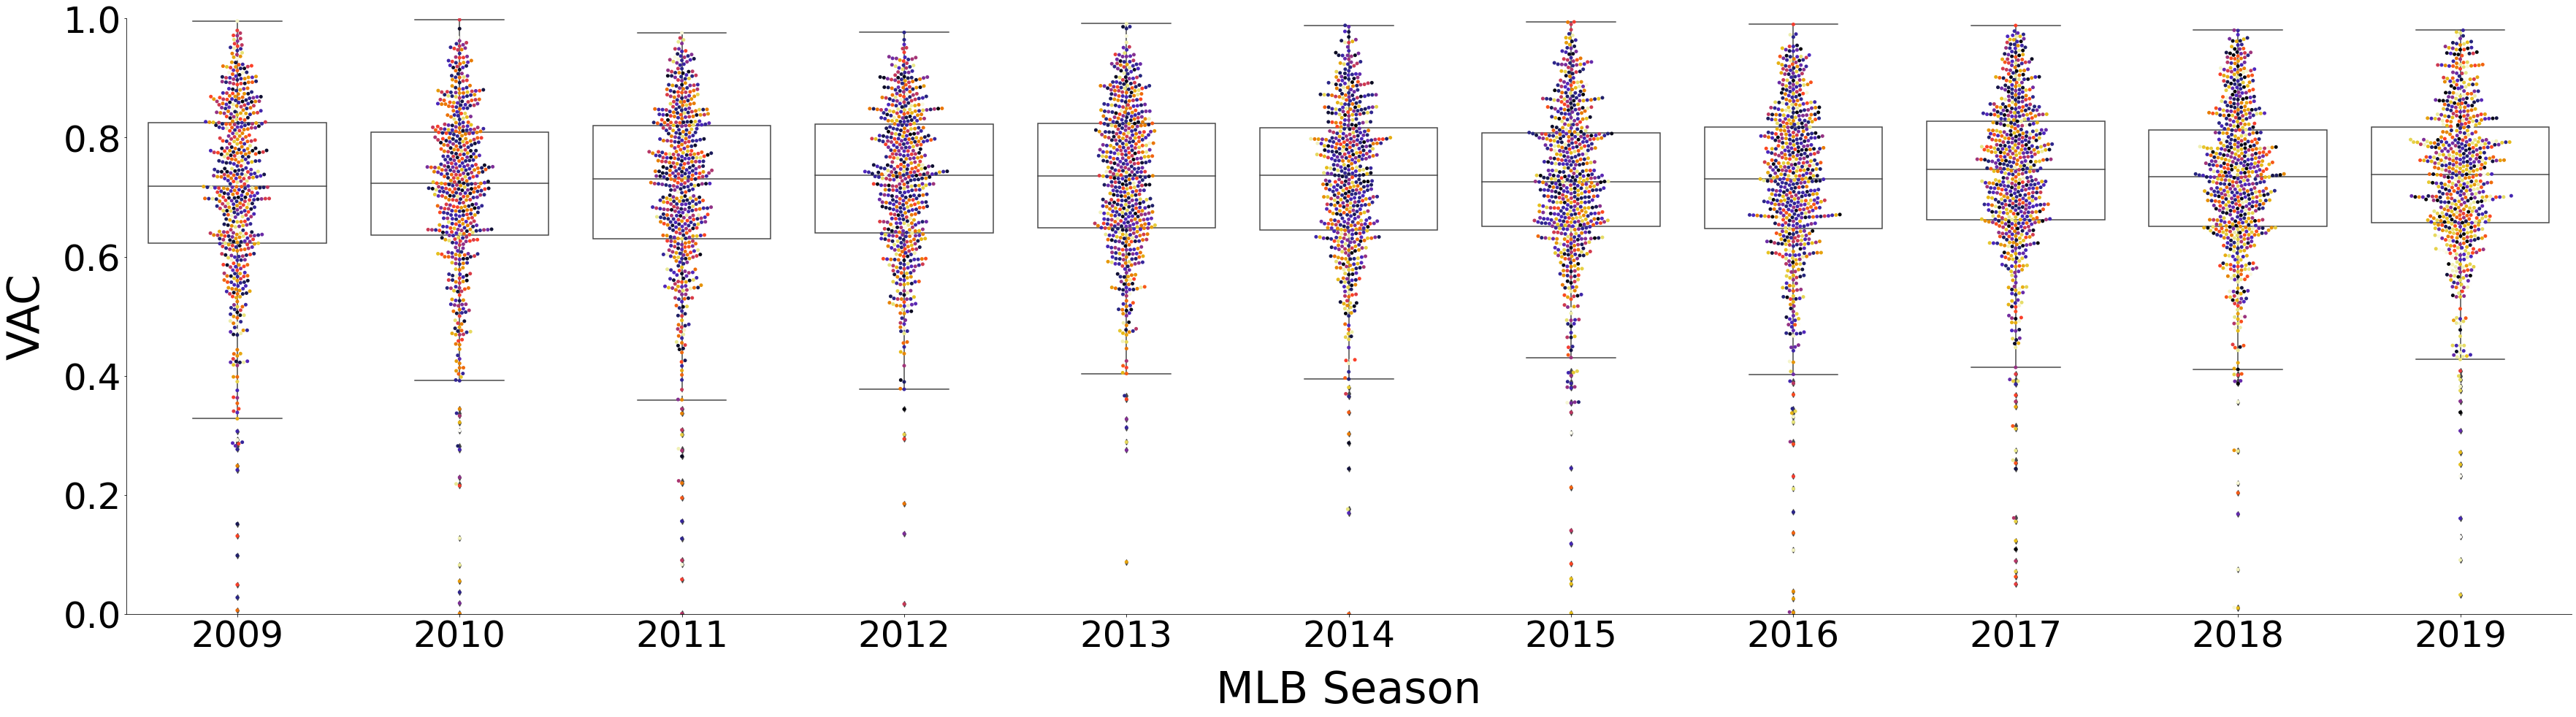

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you

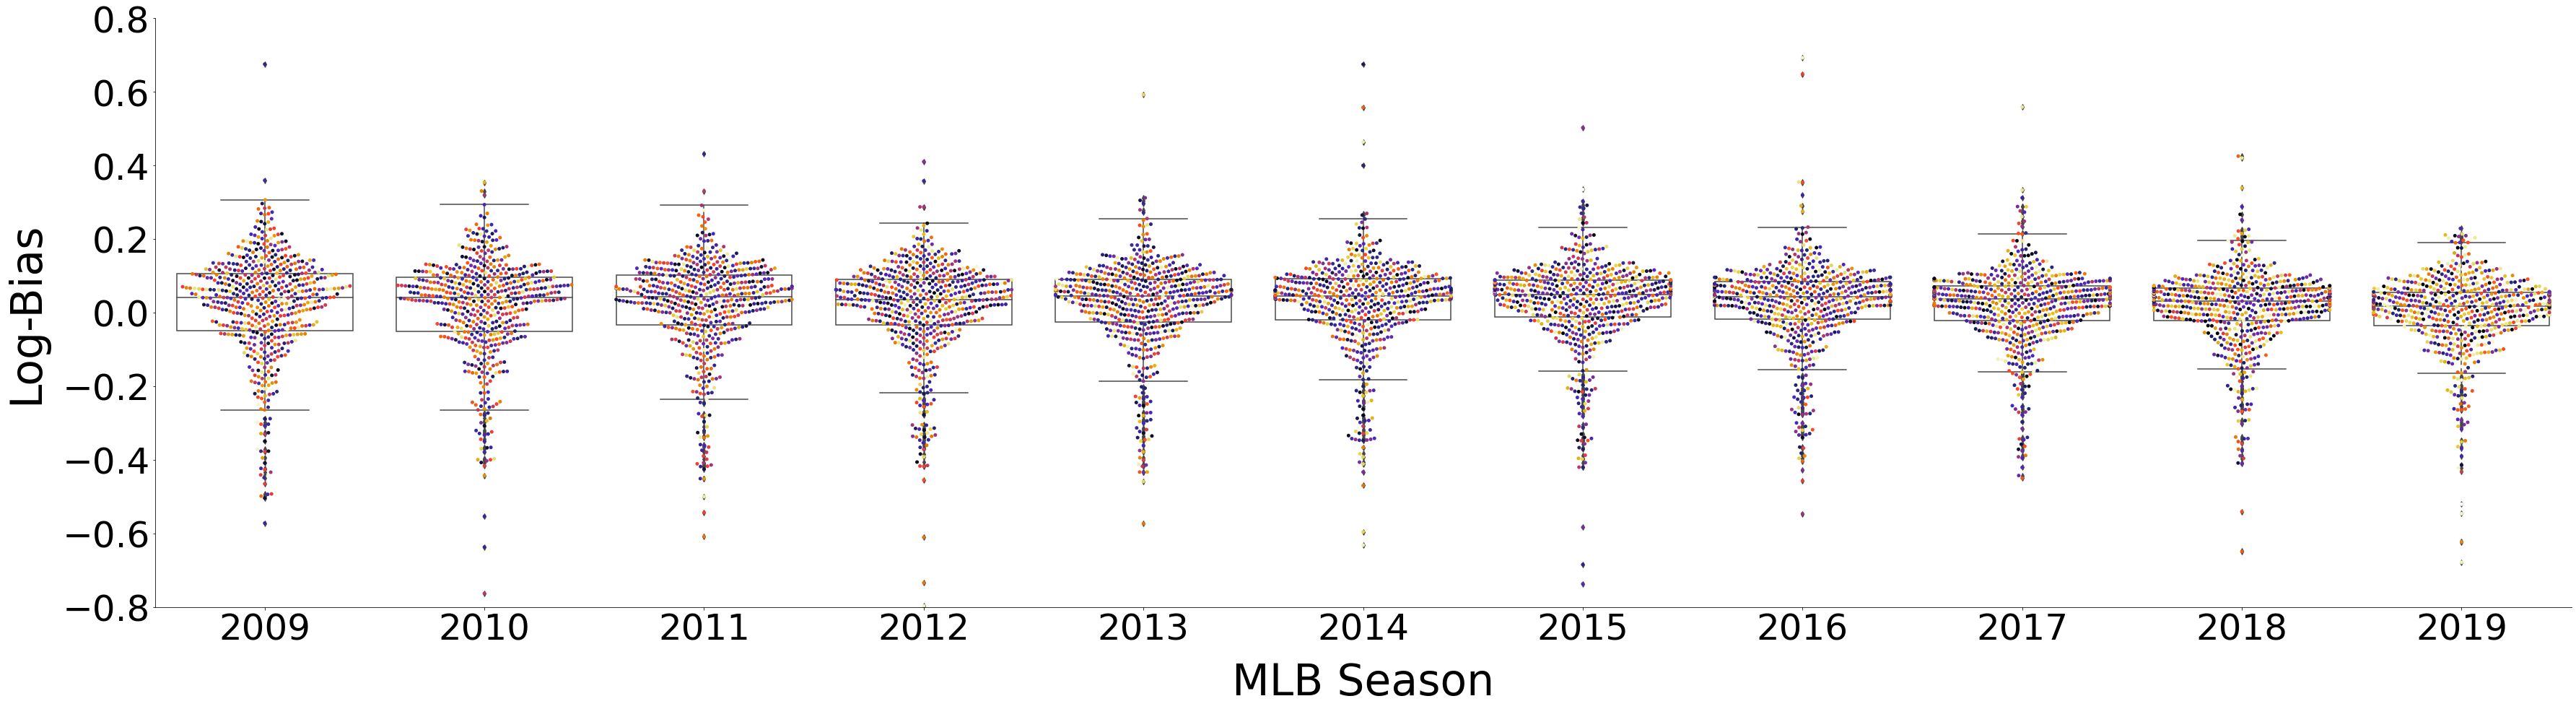

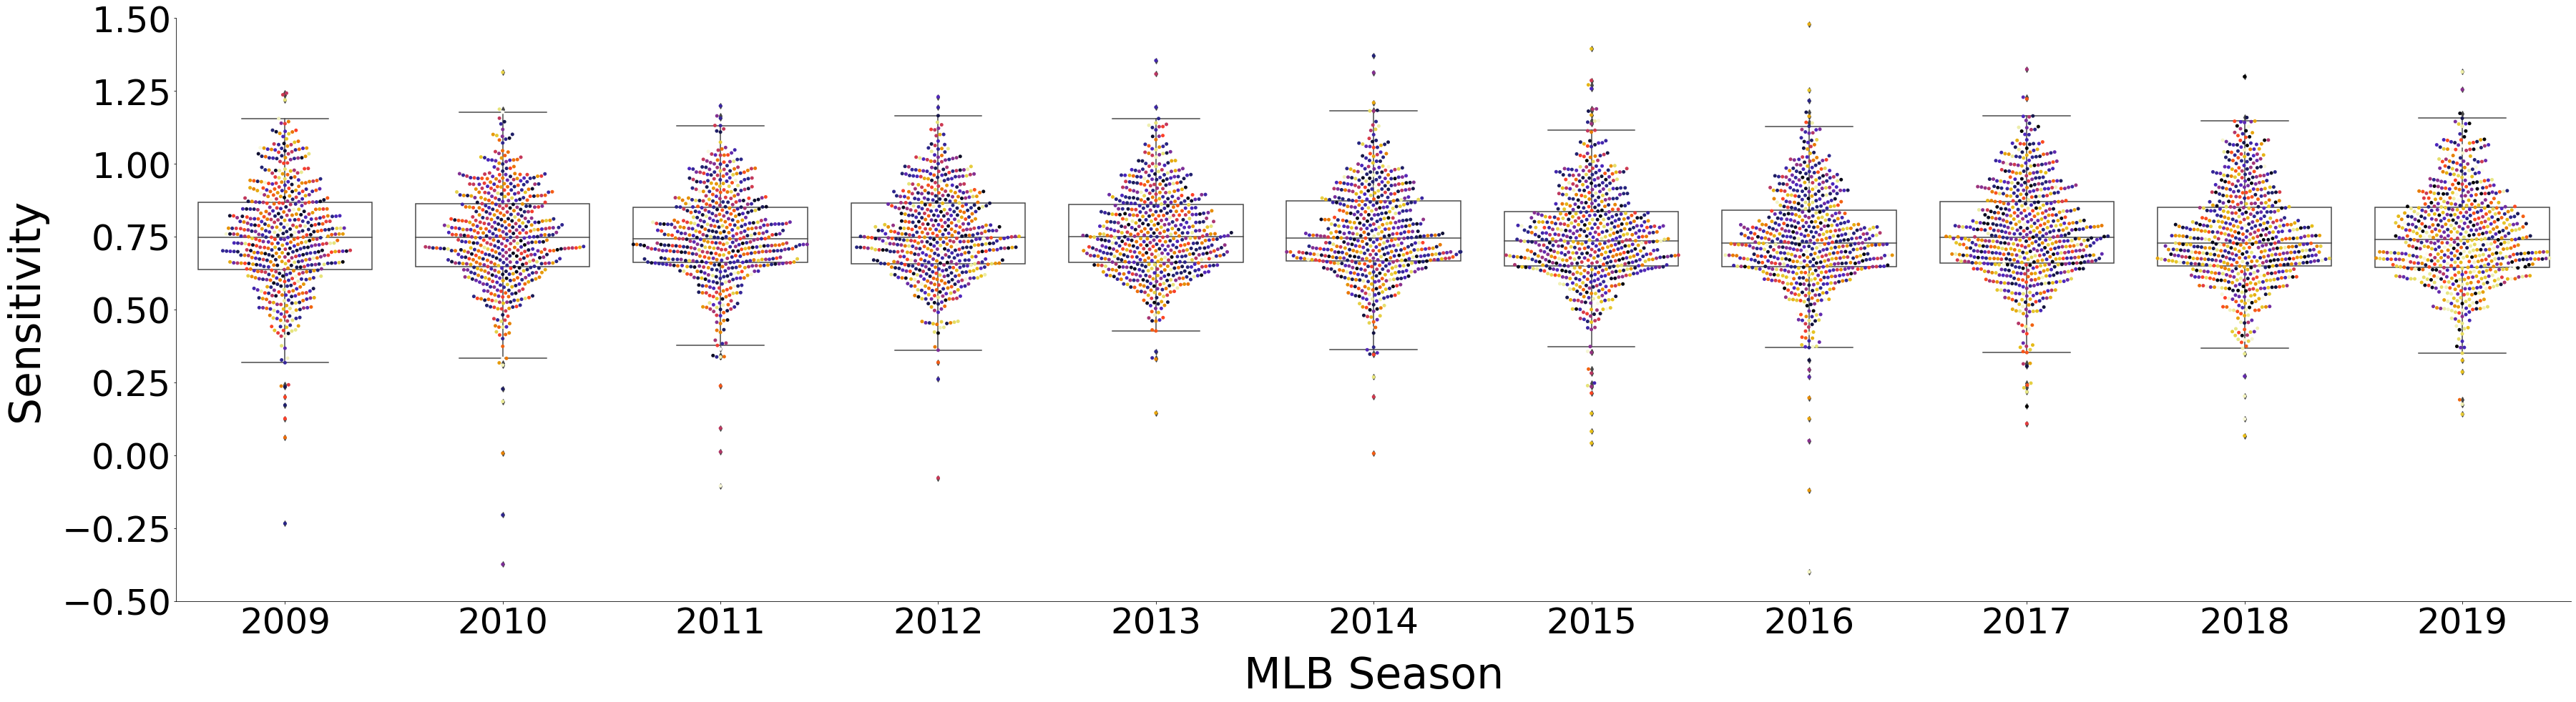

In [ ]:
season_swarm_box(y_val='VAC_SO', hue_col='Player', palette_val='CMRmap', y_label='VAC', y_min=0, y_max=1, fig_size=(60,15))
season_swarm_box(y_val='Bias_SO', hue_col='Player',palette_val='CMRmap', y_label='Log-Bias', y_min=-0.8, y_max=0.8, fig_size=(60, 15))
season_swarm_box(y_val='Sensitivity_SO', hue_col='Player', palette_val='CMRmap', y_label='Sensitivity', y_min=-0.5, y_max=1.5, fig_size=(60, 15))

# Add starter-reliever label to the dataframe

In [ ]:
# Read in the df of starting pitchers for each season
starters = pd.read_excel('Starting_Pitchers_09_19.xlsx')
starters

season_2019      season_2018  ...     season_2010       season_2009
0         Austin Adams     Chance Adams  ...  Brett Anderson    Alfredo Aceves
1         Austin Adams  Sandy Alcantara  ...    Jake Arrieta     Nick Adenhart
2        Dario Agrazal  Scott Alexander  ...  Bronson Arroyo    Brett Anderson
3      Sandy Alcantara     Kolby Allard  ...  Scott Atchison    Bronson Arroyo
4      Tyler Alexander   Brett Anderson  ...    Luis Atilano  Bryan Augenstein
..                 ...              ...  ...             ...               ...
425     Ryan Yarbrough              NaN  ...             NaN               NaN
426       Gabriel Ynoa              NaN  ...             NaN               NaN
427         Alex Young              NaN  ...             NaN               NaN
428         T.J. Zeuch              NaN  ...             NaN               NaN
429  Jordan Zimmermann              NaN  ...             NaN               NaN

[430 rows x 11 columns]

In [ ]:
# Create list of starter for each season
starters_19 = starters['season_2019'].dropna().unique().tolist()
starters_18 = starters['season_2018'].dropna().unique().tolist()
starters_17 = starters['season_2017'].dropna().unique().tolist()
starters_16 = starters['season_2016'].dropna().unique().tolist()
starters_15 = starters['season_2015'].dropna().unique().tolist()
starters_14 = starters['season_2014'].dropna().unique().tolist()
starters_13 = starters['season_2013'].dropna().unique().tolist()
starters_12 = starters['season_2012'].dropna().unique().tolist()
starters_11 = starters['season_2011'].dropna().unique().tolist()
starters_10 = starters['season_2010'].dropna().unique().tolist()
starters_09 = starters['season_2009'].dropna().unique().tolist()

In [ ]:
# Create lists of 'starter' vs 'reliever' labels for each observation in the 
# player_fits df. 
start_relief = []

for i in range(len(player_fits)):
  season = player_fits['Season'][i]
  if season==2009:
    if player_fits['Player'][i] in starters_09:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2010:
    if player_fits['Player'][i] in starters_10:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2011:
    if player_fits['Player'][i] in starters_11:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2012:
    if player_fits['Player'][i] in starters_12:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2013:
    if player_fits['Player'][i] in starters_13:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2014:
    if player_fits['Player'][i] in starters_14:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2015:
    if player_fits['Player'][i] in starters_15:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2016:
    if player_fits['Player'][i] in starters_16:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2017:
    if player_fits['Player'][i] in starters_17:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2018:
    if player_fits['Player'][i] in starters_18:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  elif season==2019:
    if player_fits['Player'][i] in starters_19:
      start_relief.append('starter')
    else:
      start_relief.append('reliever')
  else:
    start_relief.append('Unknown')

player_fits['starter_reliever'] = start_relief

In [8]:
player_fits

Player  Season  VAC_SO  Bias_SO  Sensitivity_SO starter_reliever
0         Ian Kennedy    2010  0.6816   0.0119          0.7053          starter
1         Ian Kennedy    2011  0.7710   0.0085          0.7274          starter
2         Ian Kennedy    2012  0.8487  -0.0031          0.8474          starter
3         Ian Kennedy    2013  0.8411   0.0106          0.8292          starter
4         Ian Kennedy    2014  0.8205   0.0062          0.8148          starter
...               ...     ...     ...      ...             ...              ...
6682   Reggie McClain    2019  0.7575  -0.6227          0.6968          starter
6683  Taylor Guilbeau    2019  0.8609  -0.2171          1.0024         reliever
6684  Brandon Brennan    2019  0.8238  -0.1436          1.0210         reliever
6685    Yusei Kikuchi    2019  0.7035  -0.0106          0.8028          starter
6686    Chris Rearick    2015  0.7962   0.0223          0.5082         reliever

[6687 rows x 6 columns]

In [16]:
def season_swarm_start_rel(x_val, y_val,  y_label, color=None, palette_val=None, hue_col=None, y_min=None, y_max=None, fig_size=(15, 12)):
  f, ax = plt.subplots(figsize=fig_size)
  sns.swarmplot(x=x_val, y=y_val, hue=hue_col, data=player_fits, color=color, palette=palette_val)
  plt.xticks(ticks=[0, 1], labels=['Starters', 'Relievers'], fontsize=60)
  plt.ylim(y_min, y_max)
  plt.yticks(fontsize=60)
  plt.xlabel("", fontsize=40, labelpad=(16))
  plt.ylabel(y_label, fontsize=60, labelpad=(16))
  plt.legend(loc='upper center', fontsize=20, frameon=False)
  ax.get_legend().remove()
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

No handles with labels found to put in legend.


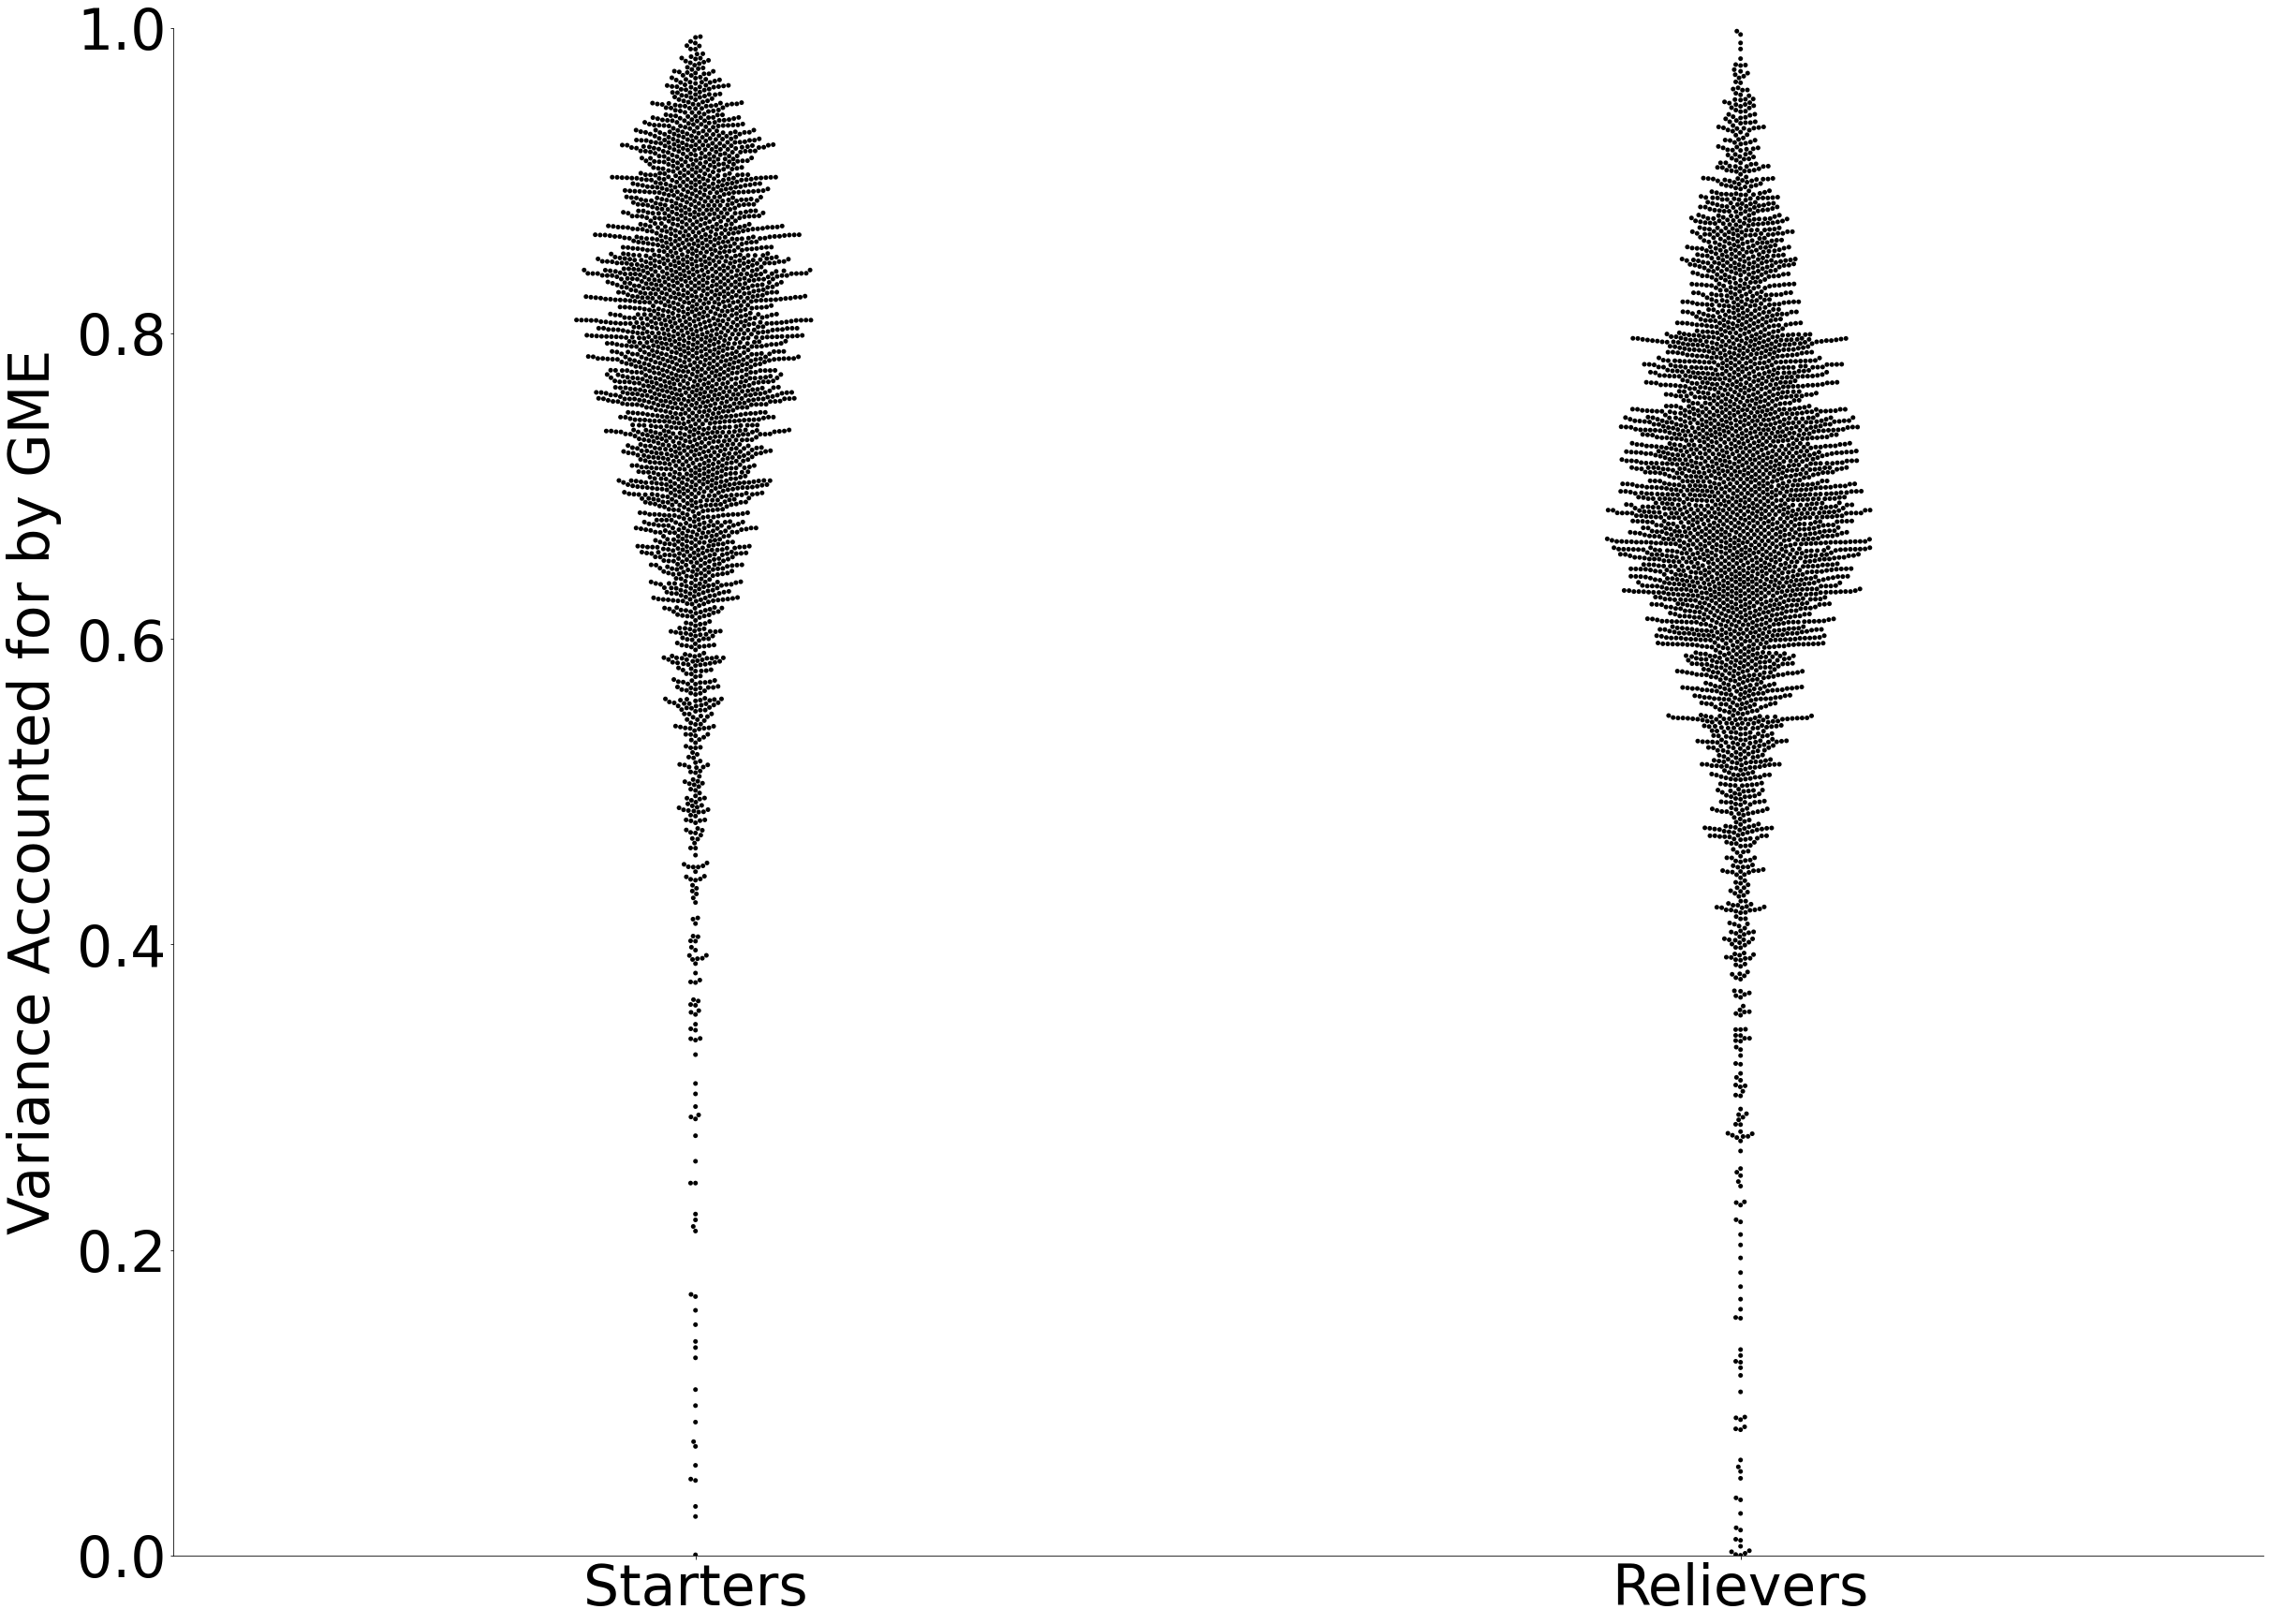

No handles with labels found to put in legend.


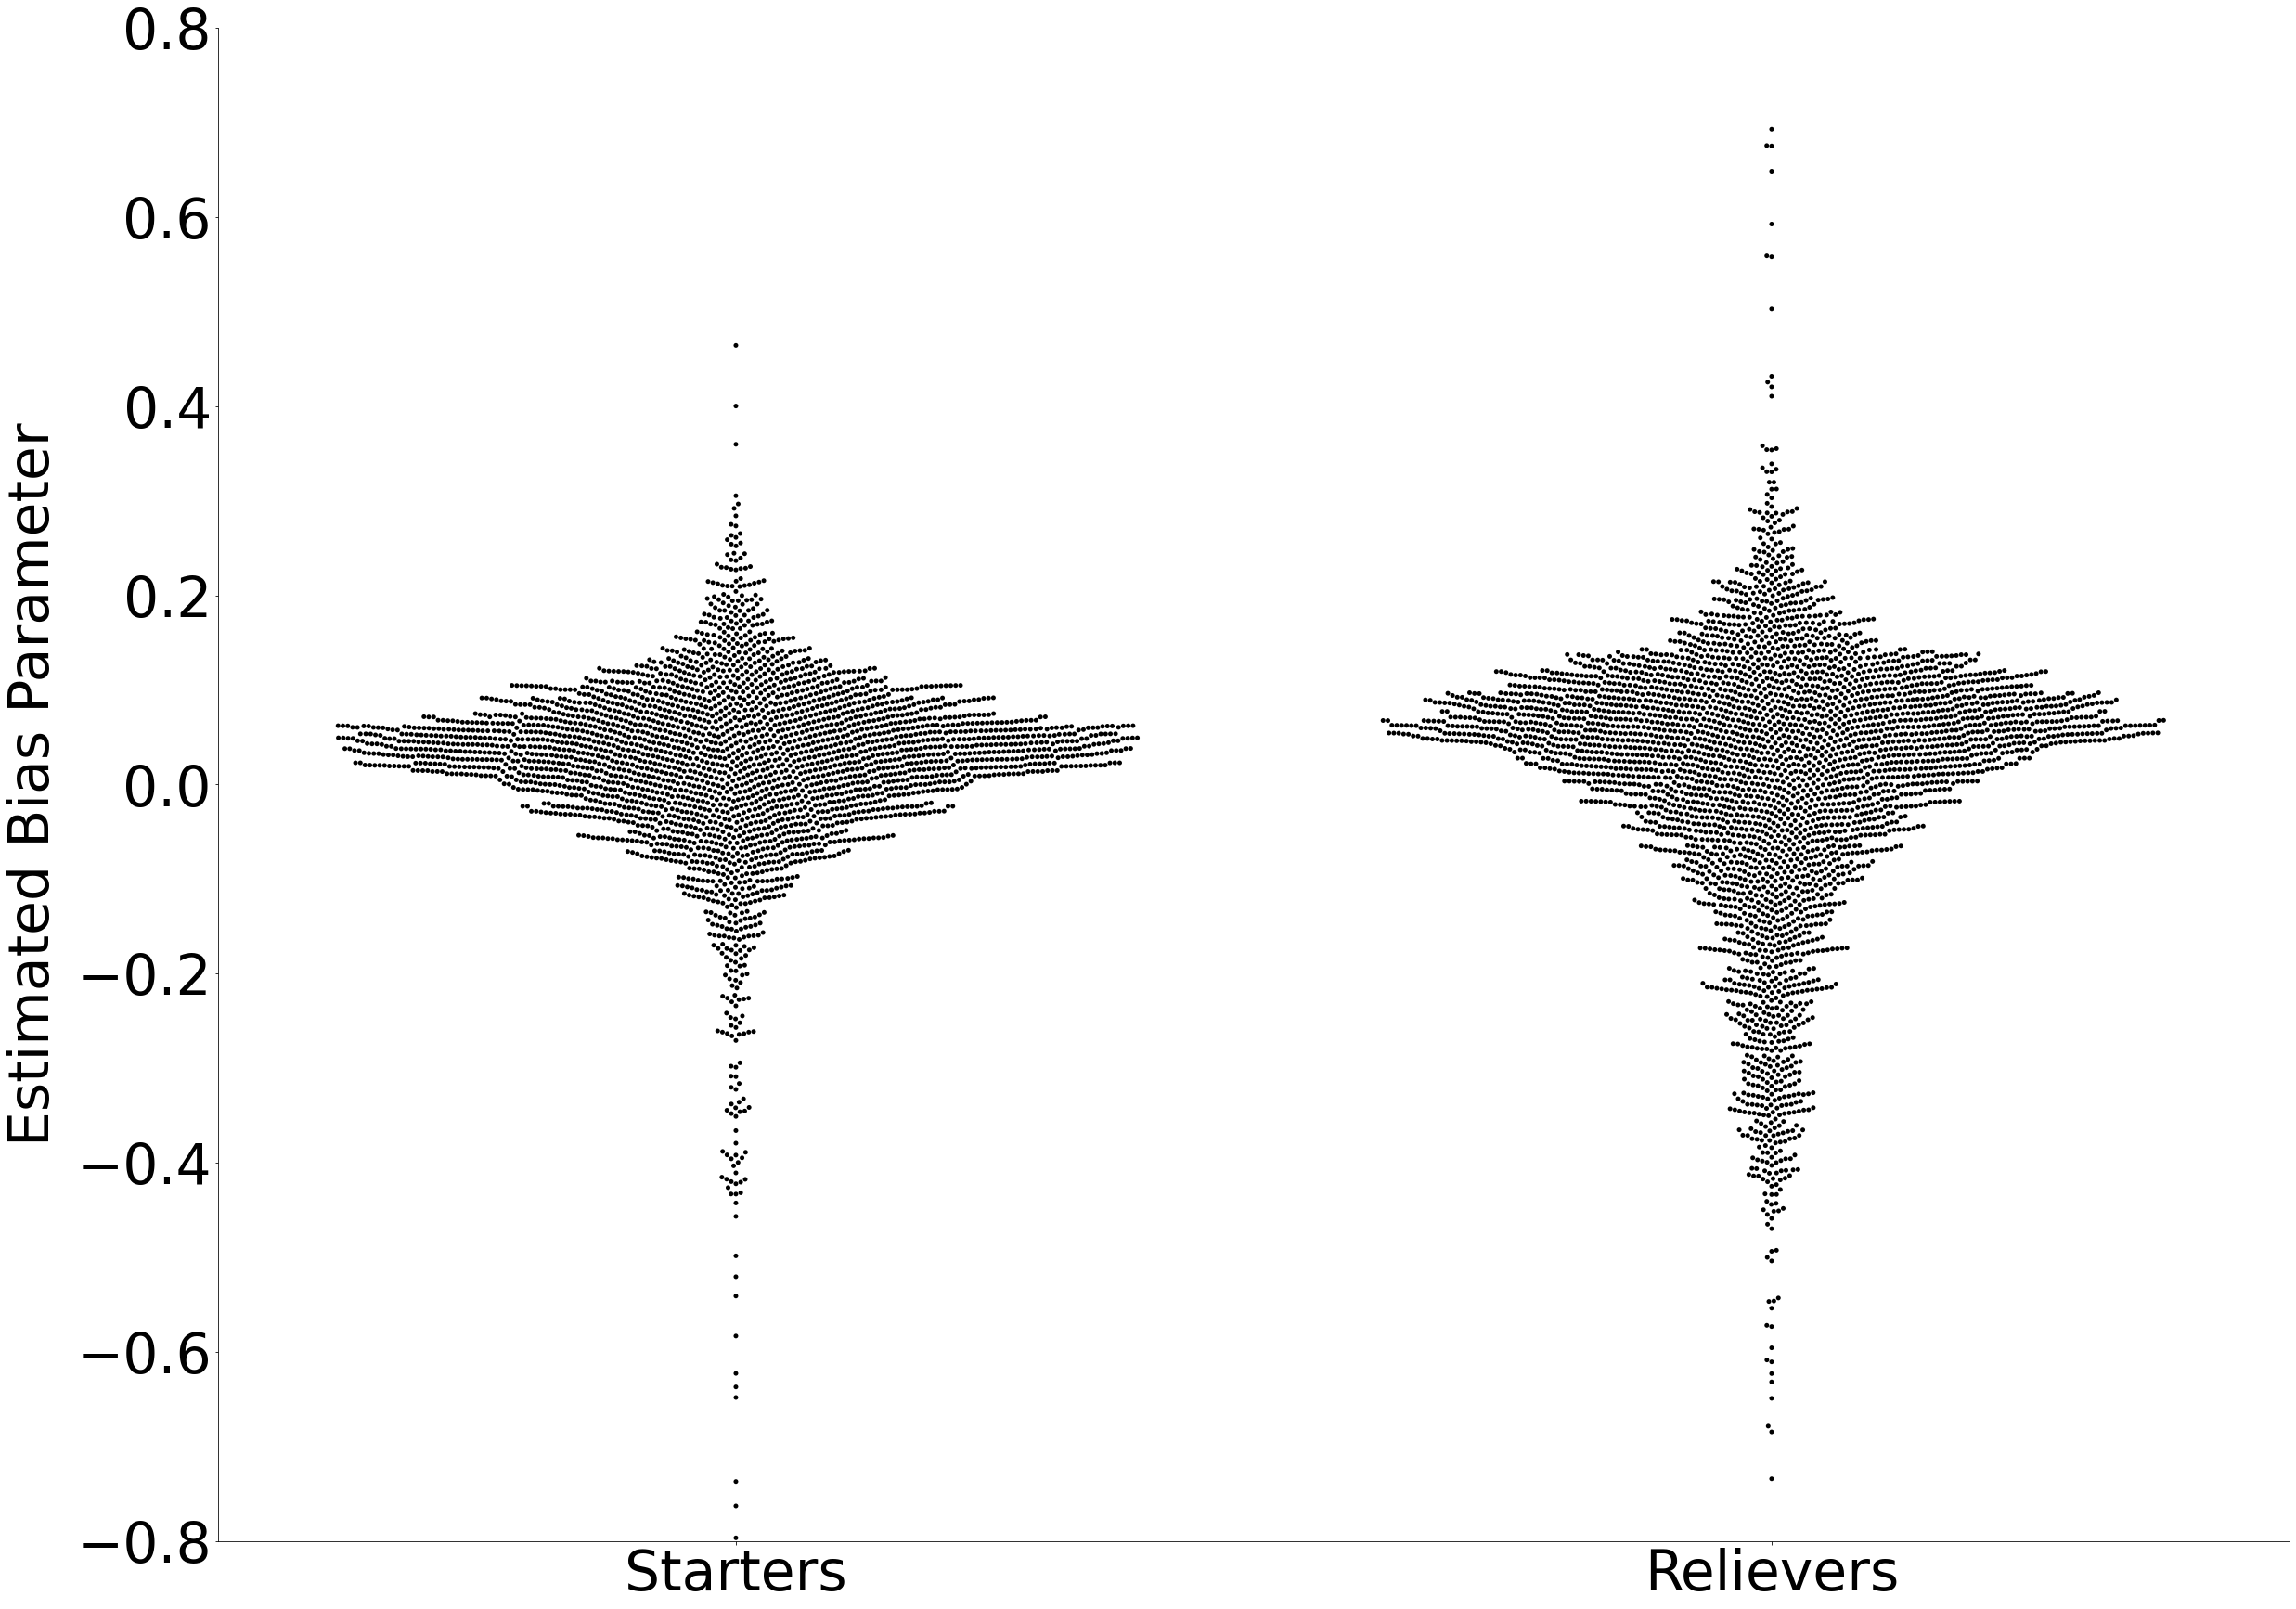

No handles with labels found to put in legend.


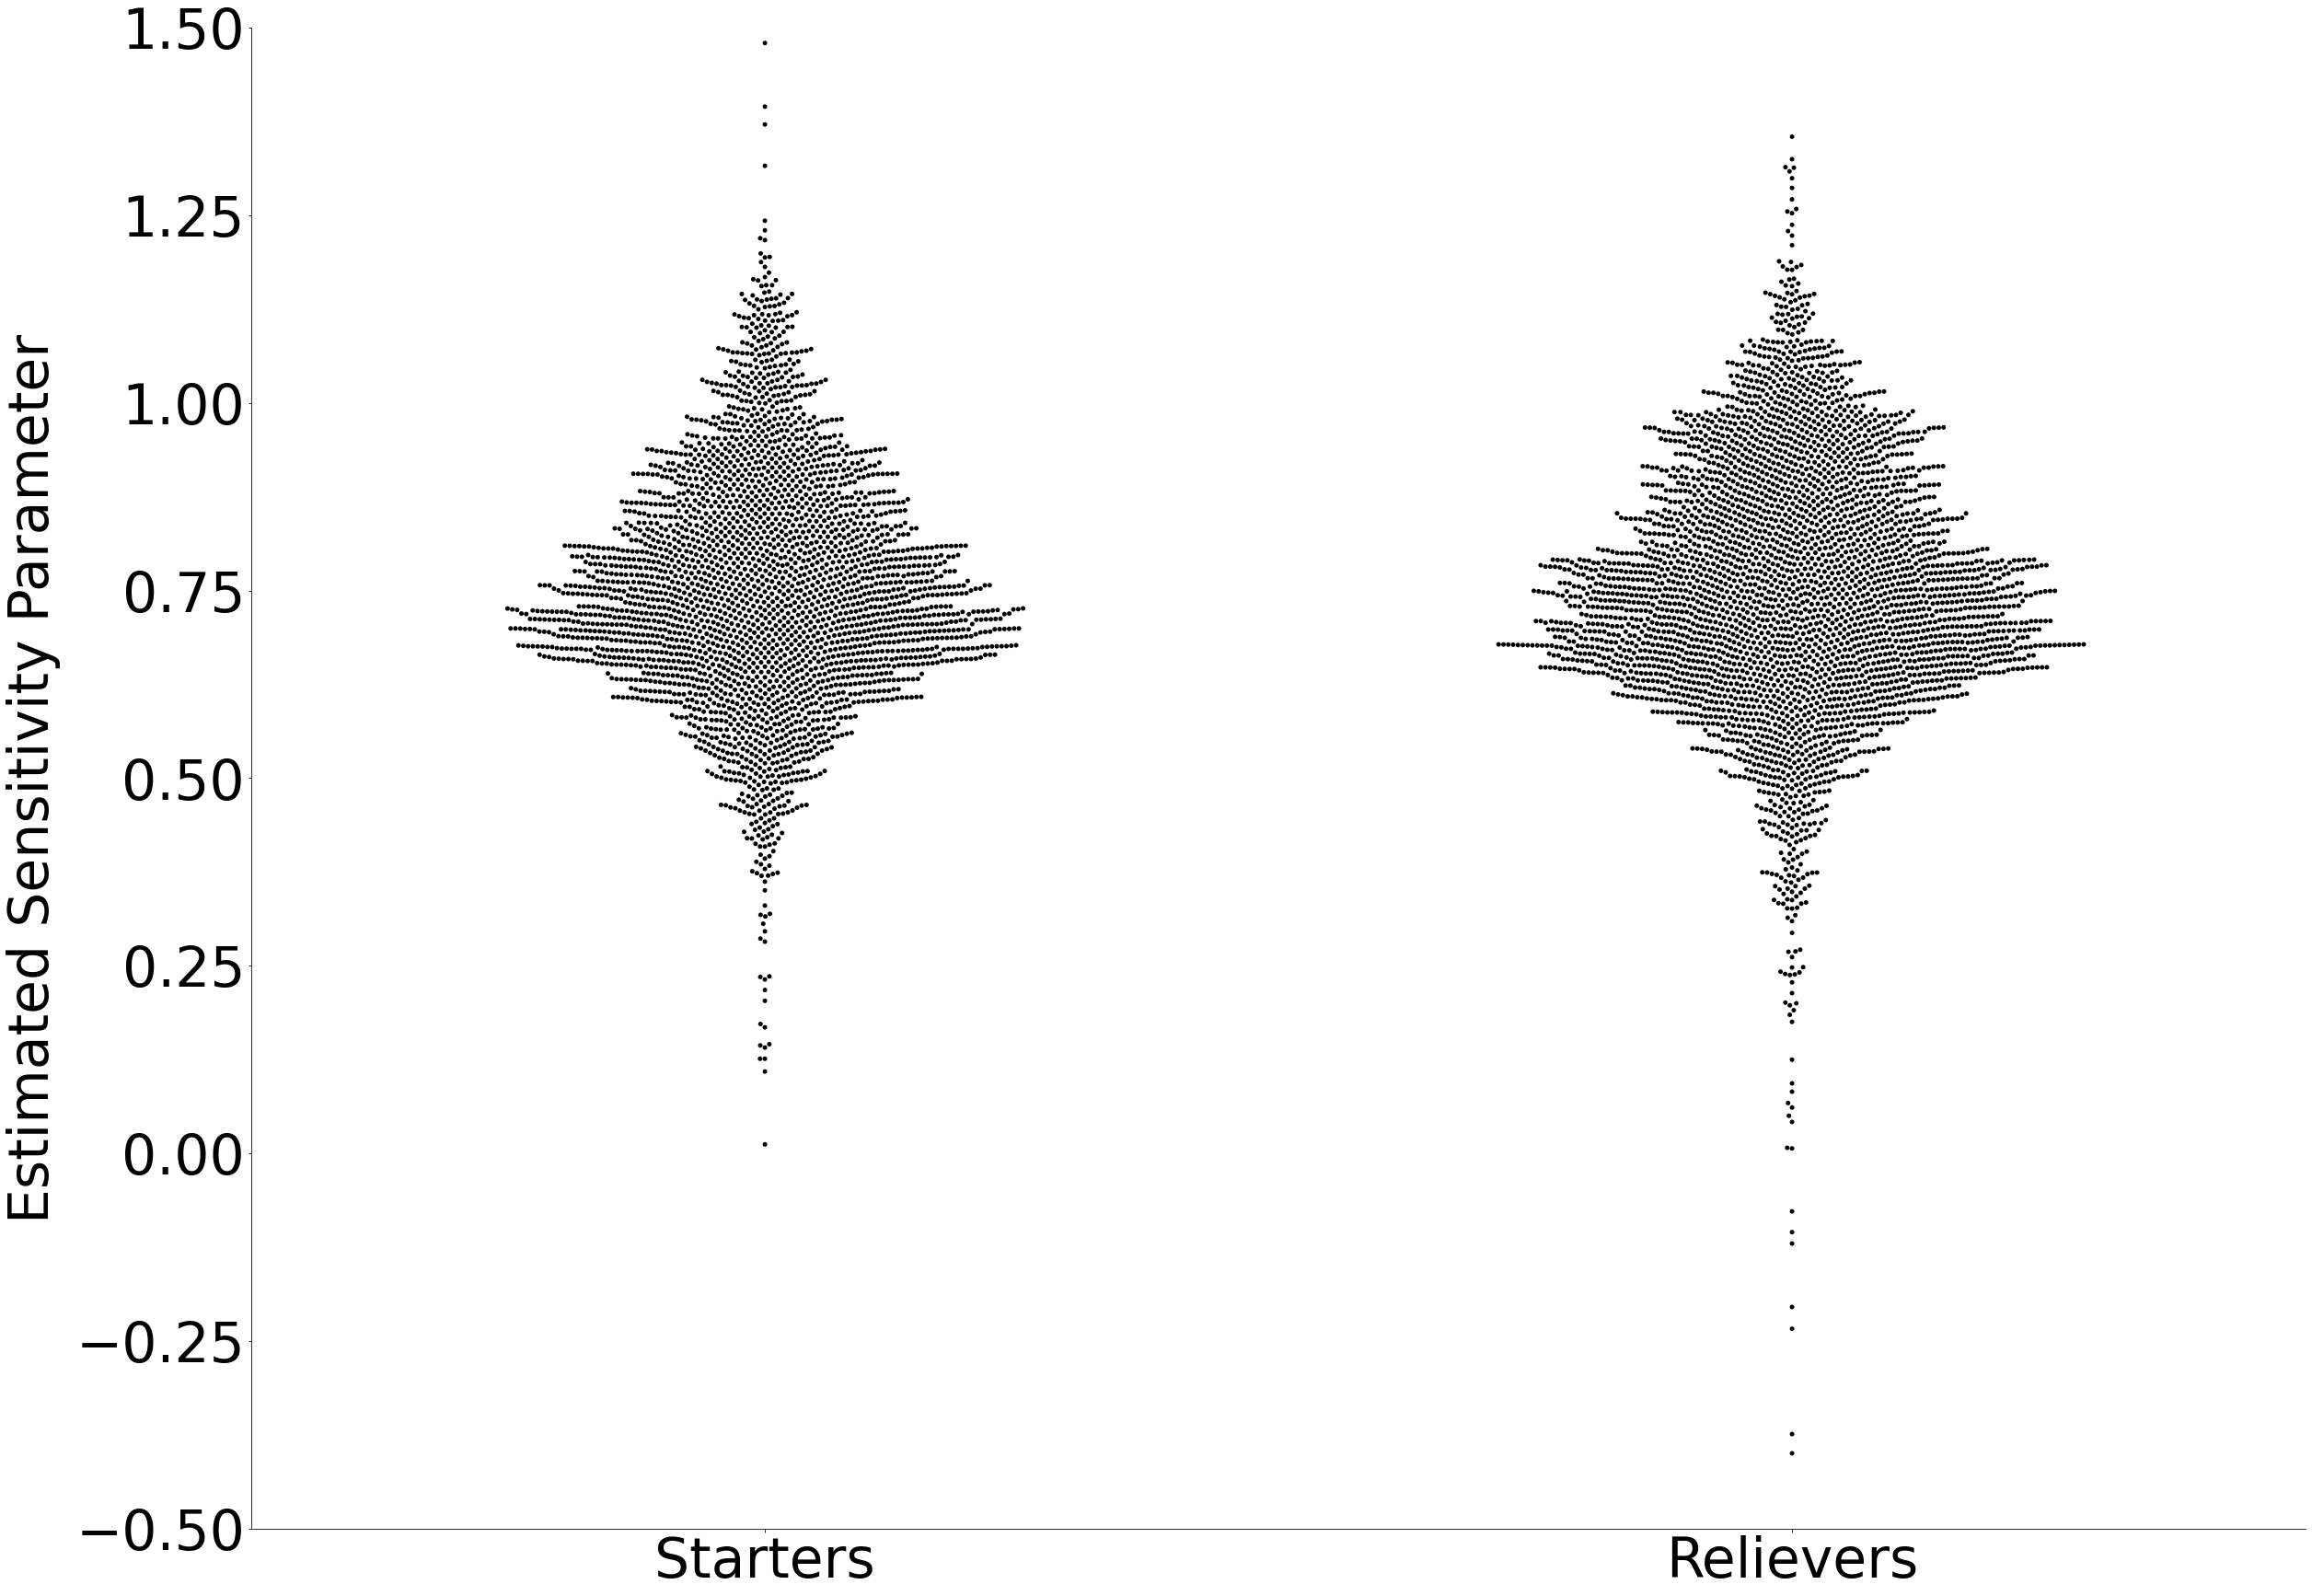

In [20]:
season_swarm_start_rel(x_val='starter_reliever', y_val='VAC_SO', color='black', y_label='Variance Accounted for by GME', y_min=0, y_max=1, fig_size=(40,30))
season_swarm_start_rel(x_val='starter_reliever', y_val='Bias_SO', color='black', y_label='Estimated Bias Parameter', y_min=-0.8, y_max=0.8, fig_size=(40, 30))
season_swarm_start_rel(x_val='starter_reliever', y_val='Sensitivity_SO', color='black', y_label='Estimated Sensitivity Parameter', y_min=-0.5, y_max=1.5, fig_size=(40, 30))

In [44]:
# Calculate the slope of change in sensitivity and bias across seasons
from scipy import stats
uniq_p = player_fits['Player'].unique()
bias_slope = []
sensitivity_slope = []
player = []

for i in uniq_p:
  player_df = player_fits[player_fits['Player']==i]
  if len(player_df) >=5:
    b_slope = stats.linregress(player_df['Season'], player_df['Bias_SO'])
    s_slope = stats.linregress(player_df['Season'], player_df['Sensitivity_SO'])
    bias_slope.append(b_slope[0])
    sensitivity_slope.append(s_slope[0])
    player.append(i)
  else:
    continue

# Combine into a single df
param_slopes = pd.DataFrame(list(zip(player, bias_slope, sensitivity_slope)), columns=['player', 'bias', 'sensitivity'])
param_slopes = param_slopes.dropna().reset_index()
param_slopes = param_slopes.drop(['index'], axis=1)

In [45]:
# Return the min and max bias and sensitivities 
min_bias = param_slopes[param_slopes['bias']==param_slopes['bias'].min()]
max_bias = param_slopes[param_slopes['bias']==param_slopes['bias'].max()]
min_sens = param_slopes[param_slopes['sensitivity']==param_slopes['sensitivity'].min()]
max_sens = param_slopes[param_slopes['sensitivity']==param_slopes['sensitivity'].max()]

# Print them
print('Min bias:', min_bias, "\n")
print('Max bias:', max_bias, "\n")
print('Min sens:', min_sens, "\n")
print('Max sens:', max_sens, "\n")

Min bias:               player     bias  sensitivity
79  Kendall Graveman -0.14738     -0.18494 

Max bias:            player     bias  sensitivity
75  Freddy Garcia  0.21207      0.16396 

Min sens:               player     bias  sensitivity
79  Kendall Graveman -0.14738     -0.18494 

Max sens:            player     bias  sensitivity
75  Freddy Garcia  0.21207      0.16396 



In [47]:
# Add labels for highlighting
highlight = ['Kendall Graveman', 'Freddy Garcia']
high = []

for i in range(len(player_fits)):
  if player_fits['Player'][i] in highlight:
    high.append(player_fits['Player'][i])
  else:
    high.append('Population')

player_fits['demo_track'] = high

In [49]:
player_fits.demo_track.unique()

array(['Population', 'Freddy Garcia', 'Kendall Graveman'], dtype=object)

In [82]:
def season_track(y_val, y_label, y_min=None, y_max=None, fig_size=(15, 12)):
  # Separate out the dfs
  freddy_df = player_fits[player_fits['demo_track']=='Freddy Garcia']
  kendall_df = player_fits[player_fits['demo_track']=='Kendall Graveman']
  # Plot it
  f, ax = plt.subplots(figsize=fig_size)
  sns.boxplot(x="Season", y=y_val, data=player_fits, color='white')
  sns.swarmplot(x="Season", y=y_val, data=freddy_df, color='red', size=16, label='Freddy Garcia')
  sns.swarmplot(x="Season", y=y_val, data=kendall_df, color='blue', size=16, label='Kendall Graveman')
  plt.xticks(fontsize=30)
  plt.ylim(y_min, y_max)
  plt.yticks(fontsize=30)
  plt.xlabel("MLB Season", fontsize=50, labelpad=(20))
  plt.ylabel(y_label, fontsize=50, labelpad=(20))
  # plt.legend(fontsize=20, frameon=False, bbox_to_anchor=(0.975, 1), loc='upper left', ncol=5)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

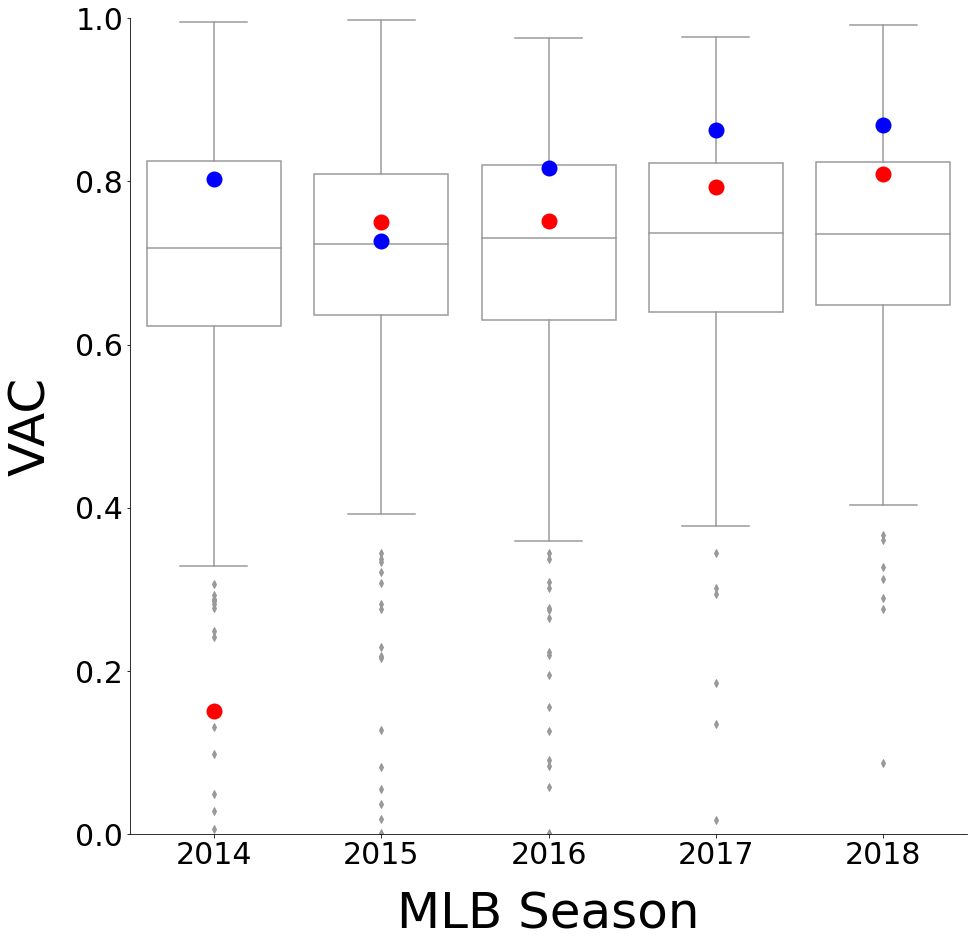

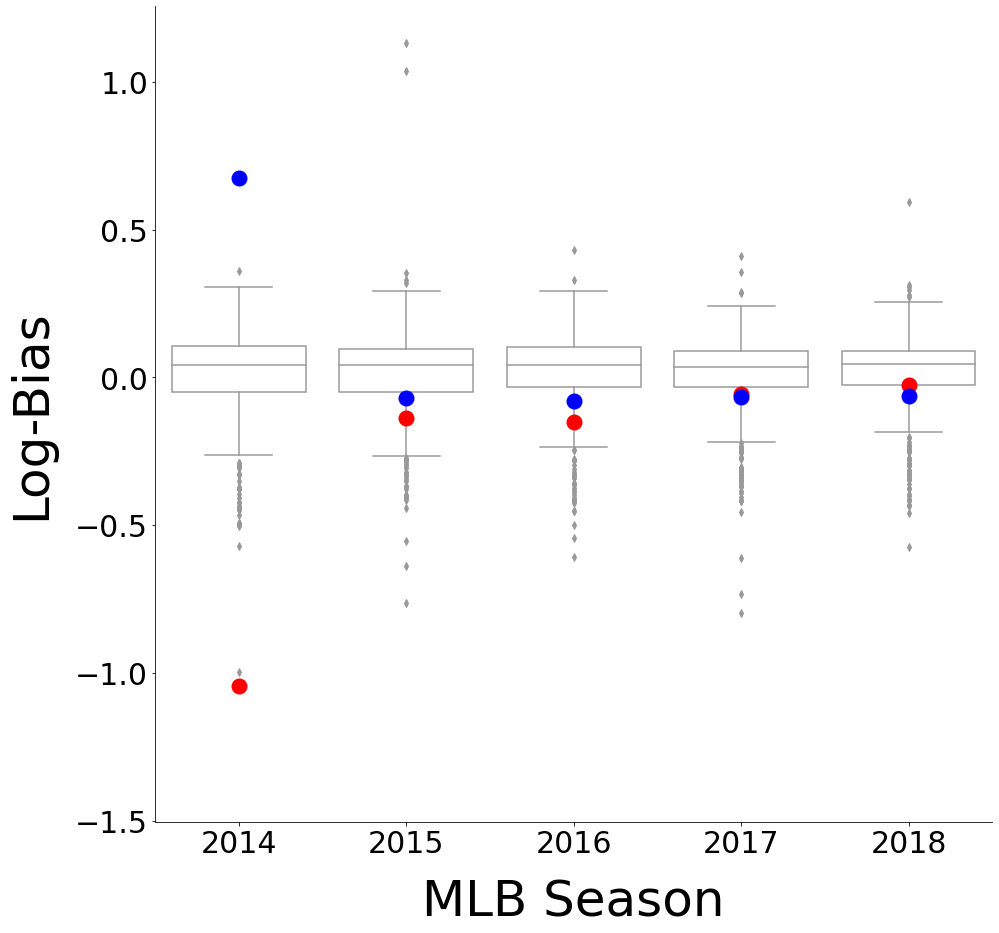

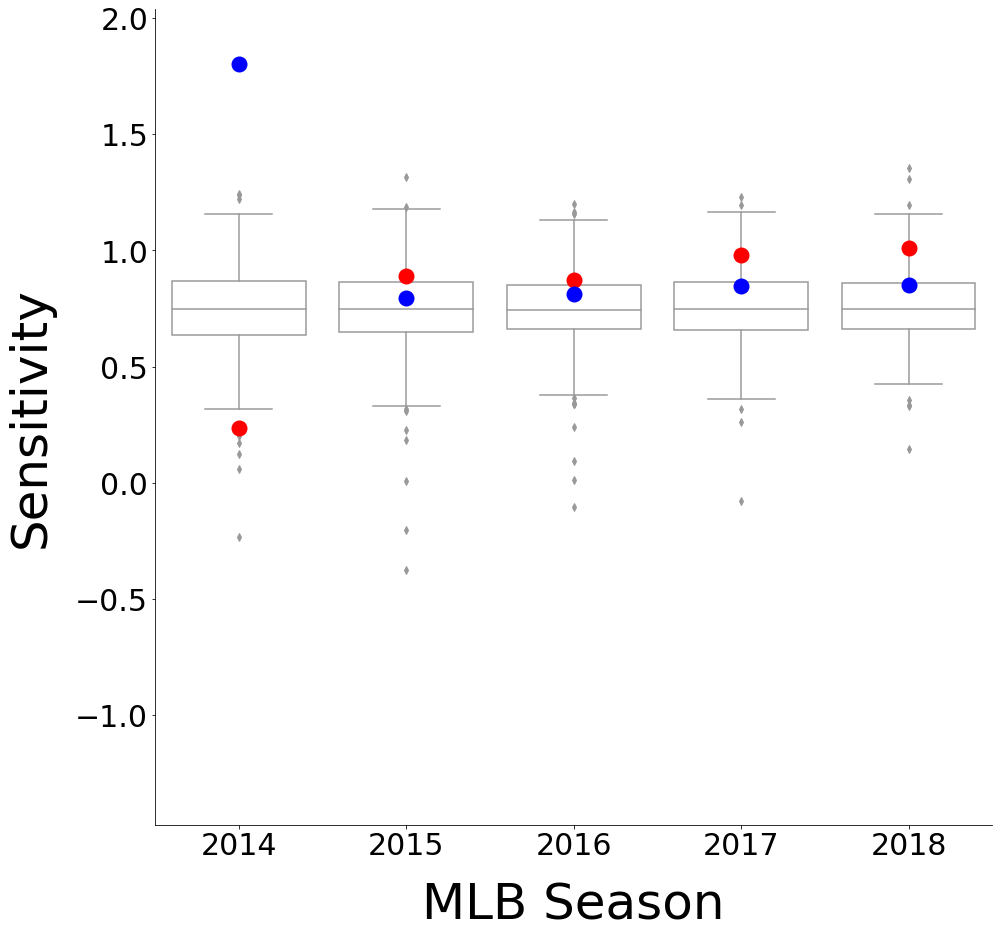

In [84]:
season_track(y_val='VAC_SO', y_label='VAC', y_min=0, y_max=1, fig_size=(15,15))
season_track(y_val='Bias_SO', y_label='Log-Bias', fig_size=(15, 15))
season_track(y_val='Sensitivity_SO', y_label='Sensitivity',fig_size=(15, 15))

In [66]:
player_fits['Season'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2009])